# Imports libraries

In [37]:
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
matplotlib.rcParams['figure.figsize'] = (8,7)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
newStopWords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's', 'co']
stop_words = stopwords.words('english')
stop_words.extend(newStopWords)

from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
lematizer = WordNetLemmatizer()

# Dataset description

This part concerns just the description of the dataset and has no incidence on future works.

In [ ]:
# !pip install langdetect

In [6]:
from langdetect import detect, DetectorFactory

# Language detection algorithm is non-deterministic, 
# which means that if you try to run it on a text which is either too short or too ambiguous,
# you might get different results everytime you run it.
DetectorFactory.seed = 0

# Detecting language and errors 
cnt = 0
for row in df.tweet_text:
    try : df.loc[cnt, 'language'] = detect(row)
    except Exception as exception:
        print("Error in language detection : tweet n°", cnt, "-->", df.tweet_text[cnt])
    cnt += 1

# df.to_csv("data/df_with_lang.csv",index=False)

Error in language detection : tweet n° 4011 --> ♪♥♪
Error in language detection : tweet n° 8695 --> 😂😂😂😂😂
Error in language detection : tweet n° 14458 --> 👧👧👧👧 …
Error in language detection : tweet n° 14691 --> ♫♪
Error in language detection : tweet n° 24110 --> ?????????
Error in language detection : tweet n° 24529 --> 5/16/15
Error in language detection : tweet n° 25032 --> 01:15:19:00
Error in language detection : tweet n° 25846 --> 5/14/15
Error in language detection : tweet n° 26069 --> 💃🍦🐙😇🌸🌟
Error in language detection : tweet n° 26461 --> 5/11/15
Error in language detection : tweet n° 27618 --> 5/17/15
Error in language detection : tweet n° 27928 --> 5/13/15
Error in language detection : tweet n° 28228 --> &#128533;
Error in language detection : tweet n° 28468 --> :-)
Error in language detection : tweet n° 28855 --> 💩
Error in language detection : tweet n° 31214 --> 5/12/15
Error in language detection : tweet n° 31286 --> .
Error in language detection : tweet n° 31676 --> 5/10/

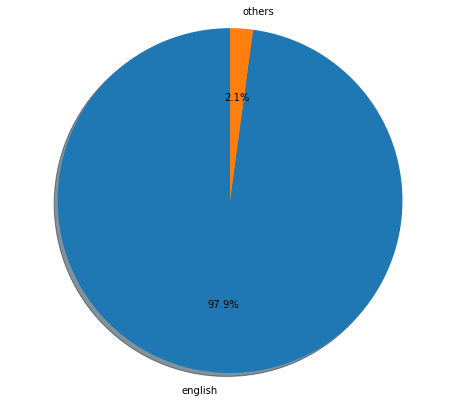

In [108]:
df_lang = pd.Series(df.language).value_counts()[:5].rename_axis('lang').reset_index(name='counts')
df_lang = df_lang.replace({'en':'english',
                           'pt':'others',
                           'af':'others',
                           'da':'others',
                           'cy':'others'})
df_lang = df_lang.groupby('lang').sum().sort_values(by='counts',ascending=False)

index = df_lang.index
values = df_lang.counts

fig1, ax1 = plt.subplots()
ax1.pie(values, labels=index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

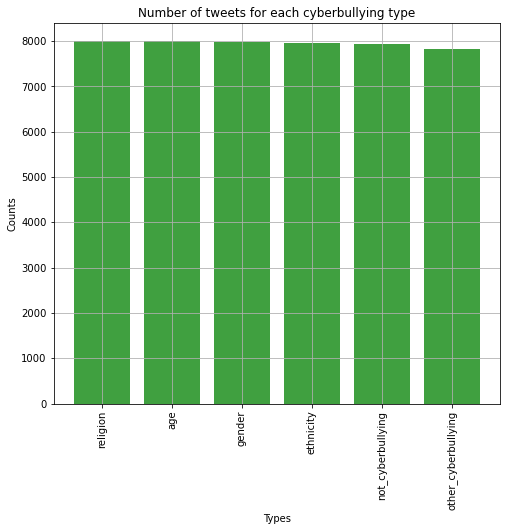

In [4]:
index = df.cyberbullying_type.value_counts().index.tolist()
values = df.cyberbullying_type.value_counts().values.tolist()

plt.bar(index, values, facecolor='g', alpha=0.75)

plt.xlabel('Types')
plt.ylabel('Counts')
plt.title('Number of tweets for each cyberbullying type')
# Rotation of the bar names
plt.xticks(index, rotation=90)
# plt.subplot_adjust(bottom=0.01, top=0.99)

plt.grid(True)
plt.show()

# I. Multi-classification Part

In [2]:
df = pd.read_csv("./data/cyberbullying_tweets.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


### I.1. Dataset preprocessing

##### Creation of the target column in df

In [5]:
types = {'age':0,
         'ethnicity':1,
         'gender':2,
         'not_cyberbullying':3,
         'other_cyberbullying':4,
         'religion':5}

df['target'] = df['cyberbullying_type'].replace(types, inplace=False)
df[:10]

,tweet_text,cyberbullying_type,target
0,"In other words #katandandre, your food was cra...",not_cyberbullying,3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,3
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,3
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying,3
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying,3
8,@stockputout everything but mostly my priest,not_cyberbullying,3
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying,3


##### Cleaning the tweet_text column

In [26]:
def clean_text(text):
    
    text = text.apply(lambda x: ''.join(w.lower() for w in x))
    text = text.apply(lambda x: ' '.join(w for w in x.split(" ") if not w.startswith('@')))
    text = text.apply(lambda x: ' '.join([lematizer.lemmatize(w) for w in x.split(" ")]))
    
    mapping = [ ('\d+', ''), ('https?:', ''), ('http?:', '') ]
    for k, v in mapping:
        text = text.str.replace(k, v)

    return text

df['tweet_text_tranformed'] = clean_text(df.tweet_text) 
df.tweet_text_tranformed[:10]

0    in other word #katandandre, your food wa crapi...
1    why is #aussietv so white? #mkr #theblock #ima...
2         a classy whore? or more red velvet cupcakes?
3    meh. :p  thanks for the head up, but not too c...
4    this is an isi account pretending to be a kurd...
5    yes, the test of god is that good or bad or in...
6    itu sekolah ya bukan tempat bully! ga jauh kay...
7    karma. i hope it bite kat on the butt. she is ...
8                      everything but mostly my priest
9    rebecca black drop out of school due to bullying:
Name: tweet_text_tranformed, dtype: object

### I.2. Training_set & Test_set

In [9]:
X = df.tweet_text_tranformed
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape:  {}".format(X_test.shape))

X_train shape: (33384,)
X_test shape:  (14308,)


### I.3. TfIdfVectorizer

In [10]:
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_df=0.7, min_df=4)
# max_df : removes term with DF higher than the 70% of the documents
# min_df : terms must have DF>=4 to be considered

start = time()
X_train_tfidf = vectorizer.fit_transform(X_train)
vec_time = time() - start

print("Extracting features from X using TfidfVectorizer")
print("n_samples: %d, n_features: %d" % X_train_tfidf.shape)
print("TfidfVectorizer takes %fs" % vec_time)

features = vectorizer.get_feature_names_out()

X_test_tfidf = vectorizer.transform(X_test)

features[:10]

Extracting features from X using TfidfVectorizer
n_samples: 33384, n_features: 18344
TfidfVectorizer takes 1.090841s


array(['__', '___', '____', 'aa', 'aaaand', 'aap', 'ab', 'abandon',
       'abandoned', 'abc'], dtype=object)

In [11]:
def top_tfidf_feats(row, features, top_n=25):
    '''Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)


def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, max_tfidf=0.3, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    D[D > max_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, max_tfidf=0.3, top_n=25):
    '''Return a list of dfs, where each df holds top_n features and their mean tfidf value
       calculated across documents with the same class label.'''
    dfs=[]
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, max_tfidf=max_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [12]:
# row = df_en.tweet_text_tranformed[0]

dfs = top_feats_by_class(X_train_tfidf, y_train, features)

assert len(np.unique(y_train)) == len(dfs)

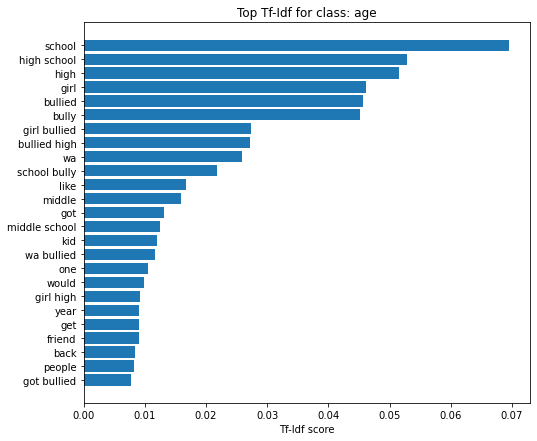

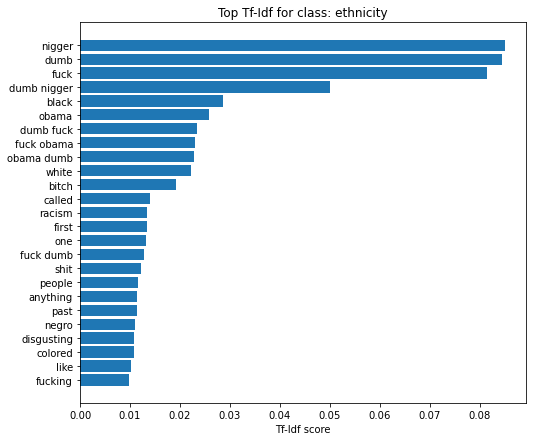

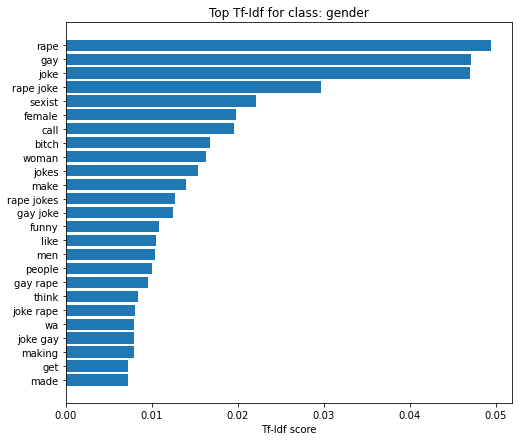

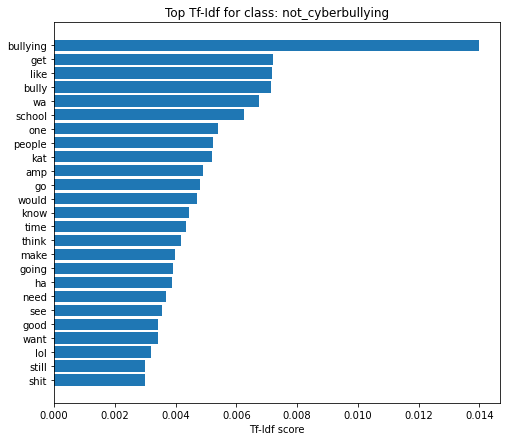

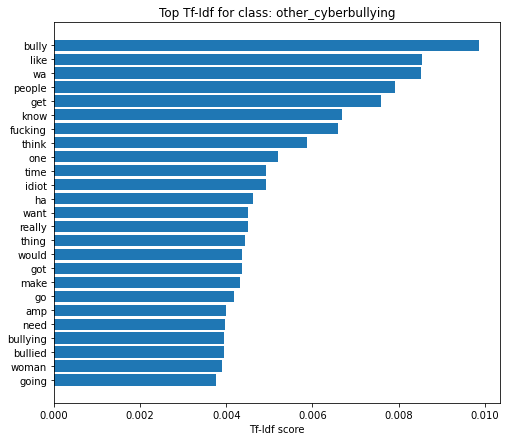

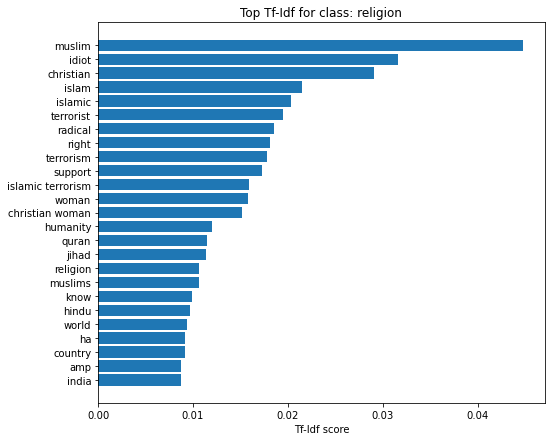

In [13]:
for i in range(len(dfs)):
    words = dfs[i]['feature'].values
    y_pos = np.arange(len(words))
    score = dfs[i]['tfidf'].values

    fig, ax = plt.subplots()
    ax.barh(y_pos, score, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(dfs[i]['feature'].values)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Tf-Idf score')
    ax.set_title('Top Tf-Idf for class: {}'.format(list(types.keys())[list(types.values()).index(np.unique(y_train)[i])]))

    plt.show()


### I.4. Models performances

In [19]:
def benchmark(clf, X_train, y_train, X_test, y_test):
    print('_' * 80)
    print('Training: ')
    print(clf)
    t0 = time()
    fit = clf.fit(X_train, y_train)
    train_time = time() - t0
    
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0    
    
    pred_train = clf.predict(X_train)
    train_score = accuracy_score(y_train, pred_train)
    test_score = accuracy_score(y_test, pred)
    
    print("training set accuracy : %0.3f" % train_score)
    print("test set accuracy :     %0.3f" % test_score)
    print("train time :            %0.3fs" % train_time)
    print("test time :             %0.3fs" % test_time)
    
    print()
    clf_t = str(clf).split('(')[0]
    
    return clf_t, train_score, test_score, pred, pred_train, train_time, test_time, fit

results = []

for clf, name in (
(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
(DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42), "Decision Tree"),
(BaggingClassifier(DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42)), "Bagging DT"),
(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42)), "AdaBoost DT"),
(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42), "Gradient Boosting"),
(XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10), "XGBoost")  
):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train_tfidf, y_train, X_test_tfidf, y_test))

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(random_state=42)
training set accuracy : 0.968
test set accuracy :     0.813
train time :            82.834s
test time :             1.014s

Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeClassifier(max_depth=10, min_samples_split=6, random_state=42)
training set accuracy : 0.706
test set accuracy :     0.694
train time :            0.459s
test time :             0.003s

Bagging DT
________________________________________________________________________________
Training: 
BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_split=6,
                                                        random_state=42))
training set accuracy : 0.726
test set accuracy :     0.716
train time :            4.066s
test time :

##### Grid Search with Cross Validation on RandomForest

In [32]:
#Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that parameter)
cv_sets = ShuffleSplit(n_splits=10, test_size=0.33 , random_state=42)

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [10, 12],
    'n_estimators': [100, 200, 300]
}
# Create a based model
clf_rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf_rf, param_grid = param_grid, 
                           cv = cv_sets, n_jobs = -1, verbose = 2)

t0 = time()
grid_search.fit(X_train_tfidf, y_train)
grid_search_time = time() - t0

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [33]:
print("\nGridSearchCV time : %0.3fs" % grid_search_time)

print("\nThe best hyperparameters from GridSearchCV :")
print(grid_search.best_params_)

print("\nThe mean accuracy of the RandomForest with the best parameters is :")
print(grid_search.best_score_)


GridSearchCV time : 845.338s

The best hyperparameters from GridSearchCV :
{'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}

The mean accuracy of the RandomForest with the best parameters is :
0.8174003812290097


In [34]:
pred_grid_search = grid_search.predict(X_test_tfidf)

##### Confusion matrix

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix without normalization'
            
    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that comes from the dataset
    classes = unique_labels(classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
        
    fig, ax = plt.subplots(1, 1)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title = title,
           ylabel='True labels',
           xlabel='Predicted labels')
    ax.set_xticklabels(labels = classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticklabels(labels = classes, rotation=45, ha='right', rotation_mode='anchor')
        
    #Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                    ha="center", va="center", color="white" if cm[i,j]>thresh else "black")
    fig.tight_layout()
    
    return ax

Normalized confusion matrix


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted labels', ylabel='True labels'>

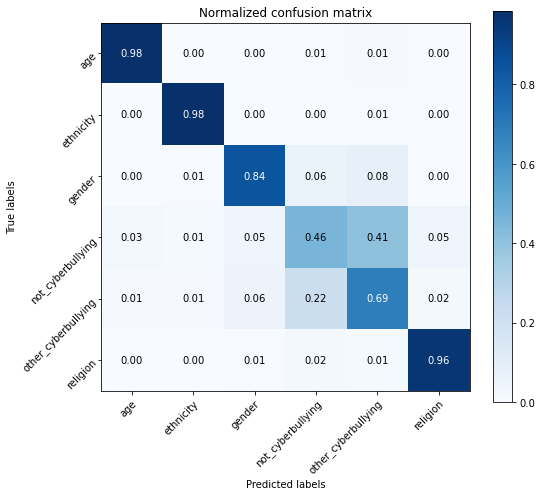

In [39]:
plot_confusion_matrix(y_test, pred_grid_search, classes=df.cyberbullying_type, normalize=True, title=None, cmap=plt.cm.Blues)

###### Classification report for Ranfom Forest

In [41]:
print(classification_report(y_test,pred_grid_search))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2349
           1       0.97      0.98      0.98      2418
           2       0.88      0.84      0.86      2343
           3       0.61      0.46      0.52      2466
           4       0.56      0.69      0.62      2391
           5       0.93      0.96      0.94      2341

    accuracy                           0.82     14308
   macro avg       0.82      0.82      0.82     14308
weighted avg       0.82      0.82      0.81     14308



# II. Binary-classification Part

In [42]:
df_bin = pd.read_csv("./data/cyberbullying_tweets.csv")

df_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


### II.1. Dataset preprocessing

##### Creation of the target column in df

In [43]:
types = {'age':0,
         'ethnicity':0,
         'gender':0,
         'not_cyberbullying':1,
         'other_cyberbullying':0,
         'religion':0}

df_bin['target'] = df_bin['cyberbullying_type'].replace(types, inplace=False)

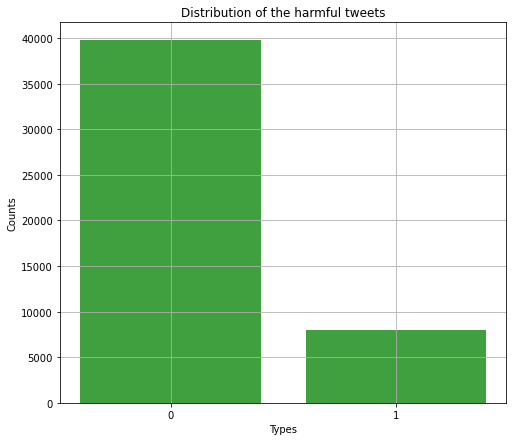

In [46]:
index = df_bin.target.value_counts().index.tolist()
values = df_bin.target.value_counts().values.tolist()

plt.bar(index, values, facecolor='g', alpha=0.75)

plt.xlabel('Types')
plt.ylabel('Counts')
plt.title('Distribution of the harmful tweets')
plt.xticks(index)

plt.grid(True)
plt.show()

##### Cleaning the tweet_text column

In [47]:
df_bin['tweet_text_tranformed'] = clean_text(df_bin.tweet_text) 

### II.2. Training_set & Test_set

In [48]:
X = df_bin.tweet_text_tranformed
y = df_bin.target

# to deal with classes imbalance : stratify=y
# data is split in a stratified fashion, using this as the class labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape:  {}".format(X_test.shape))

X_train shape: (33384,)
X_test shape:  (14308,)


### II.3. TfIdfVectorizer

In [50]:
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_df=0.7, min_df=4)
# max_df : removes term with DF higher than the 70% of the documents
# min_df : terms must have DF>=4 to be considered

start = time()
X_train_tfidf = vectorizer.fit_transform(X_train)
vec_time = time() - start

print("Extracting features from X using TfidfVectorizer")
print("n_samples: %d, n_features: %d" % X_train_tfidf.shape)
print("TfidfVectorizer takes %fs" % vec_time)

features = vectorizer.get_feature_names_out()

X_test_tfidf = vectorizer.transform(X_test)

# row = df_en.tweet_text_tranformed[0]

dfs = top_feats_by_class(X_train_tfidf, y_train, features)

assert len(np.unique(y_train)) == len(dfs)

Extracting features from X using TfidfVectorizer
n_samples: 33384, n_features: 18375
TfidfVectorizer takes 3.220811s


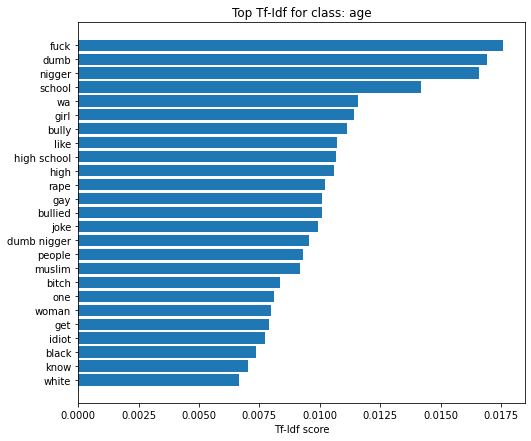

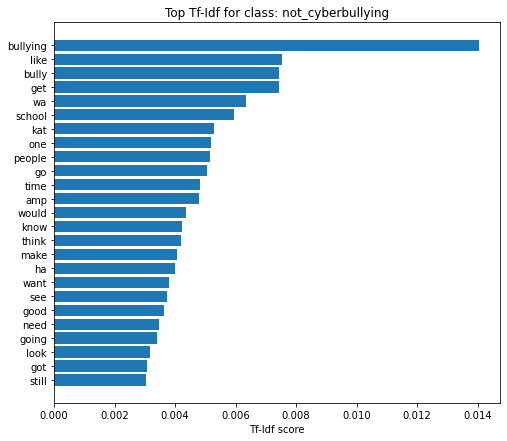

In [51]:
for i in range(len(dfs)):
    words = dfs[i]['feature'].values
    y_pos = np.arange(len(words))
    score = dfs[i]['tfidf'].values

    fig, ax = plt.subplots()
    ax.barh(y_pos, score, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(dfs[i]['feature'].values)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Tf-Idf score')
    ax.set_title('Top Tf-Idf for class: {}'.format(list(types.keys())[list(types.values()).index(np.unique(y_train)[i])]))

    plt.show()

### II.4. Models performances

In [53]:
results = []

for clf, name in (
(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
(DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42), "Decision Tree"),
(BaggingClassifier(DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42)), "Bagging DT"),
(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42)), "AdaBoost DT"),
(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42), "Gradient Boosting"),
(XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10), "XGBoost")  
):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train_tfidf, y_train, X_test_tfidf, y_test))

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(random_state=42)
training set accuracy : 0.971
test set accuracy :     0.850
train time :            208.229s
test time :             2.529s

Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeClassifier(max_depth=10, min_samples_split=6, random_state=42)
training set accuracy : 0.849
test set accuracy :     0.844
train time :            1.200s
test time :             0.016s

Bagging DT
________________________________________________________________________________
Training: 
BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_split=6,
                                                        random_state=42))
training set accuracy : 0.848
test set accuracy :     0.846
train time :            8.988s
test time 

##### Confusion matrix

Confusion matrix without normalization


<AxesSubplot:title={'center':'Confusion matrix without normalization'}, xlabel='Predicted labels', ylabel='True labels'>

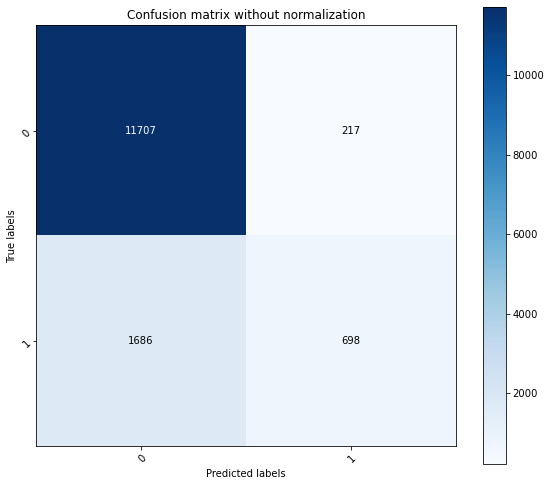

In [60]:
plot_confusion_matrix(y_test, results[4][3], classes=df_bin.target, normalize=False, title=None, cmap=plt.cm.Blues)

###### Classification report for Ranfom Forest

In [59]:
print(classification_report(y_test,results[4][3]))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     11924
           1       0.76      0.29      0.42      2384

    accuracy                           0.87     14308
   macro avg       0.82      0.64      0.67     14308
weighted avg       0.86      0.87      0.84     14308

